# Handcrafted Feature-Based Classification (COIL-20)
## Google Drive Working Version
Pipeline: HOG → Scaling → PCA vs LDA → SVM → Evaluation


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install scikit-image

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
dataset_path = '/content/drive/MyDrive/coil-20-unproc'

images = []
labels = []

for filename in sorted(os.listdir(dataset_path)):
    if filename.endswith('.png'):
        img_path = os.path.join(dataset_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img / 255.0

        images.append(img)
        label = int(filename.split('__')[0].replace('obj',''))
        labels.append(label)

X = np.array(images)
y = np.array(labels)

print("Dataset shape:", X.shape)

Dataset shape: (360, 416, 448)


In [9]:
hog_features = []

for img in X:
    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm='L2-Hys'
    )
    hog_features.append(features)

X_features = np.array(hog_features)
print("HOG feature shape:", X_features.shape)

HOG feature shape: (360, 100980)


In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
pca_linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),   # 95% variance instead of 100 comps
    ('svm', SVC(kernel='linear', C=1))
])

scores_pca_linear = cross_val_score(pca_linear_pipeline, X_features, y, cv=cv)

print("PCA + Linear SVM Accuracy: %.4f ± %.4f" %
      (scores_pca_linear.mean(), scores_pca_linear.std()))

PCA + Linear SVM Accuracy: 0.9972 ± 0.0056


In [12]:
pca_rbf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])

scores_pca_rbf = cross_val_score(pca_rbf_pipeline, X_features, y, cv=cv)

print("PCA + RBF SVM Accuracy: %.4f ± %.4f" %
      (scores_pca_rbf.mean(), scores_pca_rbf.std()))

PCA + RBF SVM Accuracy: 0.9889 ± 0.0104


In [13]:
lda_linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('svm', SVC(kernel='linear', C=1))
])

scores_lda_linear = cross_val_score(lda_linear_pipeline, X_features, y, cv=cv)

print("LDA + Linear SVM Accuracy: %.4f ± %.4f" %
      (scores_lda_linear.mean(), scores_lda_linear.std()))

LDA + Linear SVM Accuracy: 0.9417 ± 0.0333


In [14]:
lda_rbf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])

scores_lda_rbf = cross_val_score(lda_rbf_pipeline, X_features, y, cv=cv)

print("LDA + RBF SVM Accuracy: %.4f ± %.4f" %
      (scores_lda_rbf.mean(), scores_lda_rbf.std()))

LDA + RBF SVM Accuracy: 0.9500 ± 0.0299


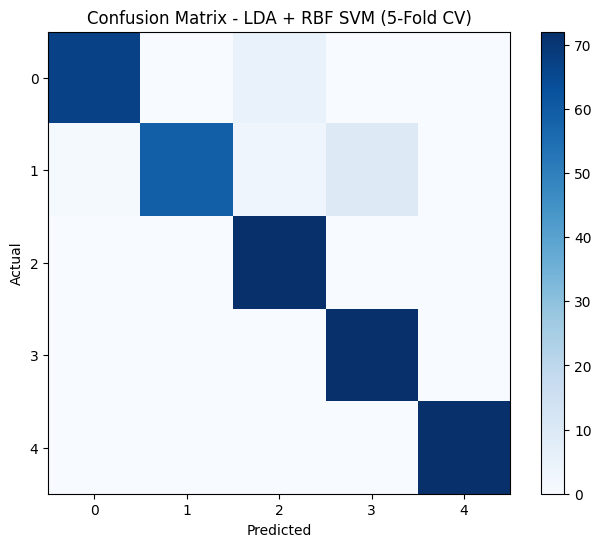

In [15]:
y_pred = cross_val_predict(lda_rbf_pipeline, X_features, y, cv=cv)

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - LDA + RBF SVM (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [16]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.93      0.96        72
           2       1.00      0.82      0.90        72
           3       0.90      1.00      0.95        72
           4       0.89      1.00      0.94        72
           5       1.00      1.00      1.00        72

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360

